In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
import numpy as np
import torch
from koopman_autoencoder import *
from load_dataset import *

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')

## Load Dataset

In [6]:
x_dataset = []
y_dataset = []
u_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u_data = build_dataset(data_dict)
        x_dataset.append(x_data)
        y_dataset.append(y_data)
        u_dataset.append(u_data)
    else:
        print(f"File not found: {data_file_path}")

File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [7]:
x_data = np.concatenate(x_dataset, axis = 0)
y_data = np.concatenate(y_dataset, axis = 0)
u_data = np.concatenate(u_dataset, axis = 0)
x_data.shape

(7221, 6957)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


# Scaling the datasets
scaler_x = StandardScaler().fit(x_data)
scaler_u = StandardScaler().fit(u_data)

x_data_scaled = scaler_x.transform(x_data)
y_data_scaled = scaler_x.transform(y_data)
u_data_scaled = scaler_u.transform(u_data)

shuffled_indices = np.arange(len(x_data))
np.random.shuffle(shuffled_indices)

x_data_scaled = x_data_scaled[shuffled_indices]
y_data_scaled = y_data_scaled[shuffled_indices]
u_data_scaled = u_data_scaled[shuffled_indices]

x_train, x_test = train_test_split(x_data_scaled, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y_data_scaled, test_size=0.2, random_state=42)
u_train, u_test = train_test_split(u_data_scaled, test_size=0.2, random_state=42)


In [9]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR


x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
u_train = torch.tensor(u_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
u_test = torch.tensor(u_test, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(x_train, y_train, u_train)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [10]:
n_input = x_data.shape[1]
layer_sizes_dic = [128, 128, 128, 128]
layer_sizes_m = [128, 64, 64, 128]

n_psi_train = 256
u_dim = 3

In [11]:
model_psi, model_inv_psi, model_autoencoder, model_correction = BuildNonlinearModel(n_input, layer_sizes_dic, layer_sizes_m, n_psi_train, u_dim)

## Test for autoencoder

In [12]:
# Define the optimizer
optimizer_autoencoder = Adam(list(model_autoencoder.parameters()) , lr=0.001)
scheduler = StepLR(optimizer_autoencoder, step_size=50, gamma=0.8)

mse_loss = nn.MSELoss()

# Initialize a list to store the loss values
train_losses = []
val_losses = []

In [13]:
# Training process

epoches = 1200

for epoch in range(epoches):
    for x_batch, y_batch, u_batch in data_loader:
        # Forward propagation
        optimizer_autoencoder.zero_grad()
        loss = mse_loss(x_batch, model_autoencoder(x_batch))
        loss.backward()
        optimizer_autoencoder.step()
        
    
    train_loss = mse_loss(x_train, model_autoencoder(x_train))
    train_losses.append(train_loss.item())
        
    # Test the model
    with torch.no_grad():
        val_loss = mse_loss(x_test, model_autoencoder(x_test))
        val_losses.append(val_loss.item())

    current_lr = optimizer_autoencoder.param_groups[0]['lr']
    scheduler.step()
    print(f'Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Learning Rate: {current_lr}')


Epoch: 0, Training Loss: 0.0599786750972271, Validation Loss: 0.05951186642050743, Learning Rate: 0.001
Epoch: 1, Training Loss: 0.0328616201877594, Validation Loss: 0.03236745670437813, Learning Rate: 0.001
Epoch: 2, Training Loss: 0.021297432482242584, Validation Loss: 0.02162916399538517, Learning Rate: 0.001
Epoch: 3, Training Loss: 0.028698712587356567, Validation Loss: 0.02884109690785408, Learning Rate: 0.001
Epoch: 4, Training Loss: 0.016017509624361992, Validation Loss: 0.015137340873479843, Learning Rate: 0.001
Epoch: 5, Training Loss: 0.019567901268601418, Validation Loss: 0.01947798952460289, Learning Rate: 0.001
Epoch: 6, Training Loss: 0.018393149599432945, Validation Loss: 0.018400220200419426, Learning Rate: 0.001
Epoch: 7, Training Loss: 0.02183493599295616, Validation Loss: 0.021818295121192932, Learning Rate: 0.001
Epoch: 8, Training Loss: 0.02937791310250759, Validation Loss: 0.029951095581054688, Learning Rate: 0.001
Epoch: 9, Training Loss: 0.01822722889482975, Va

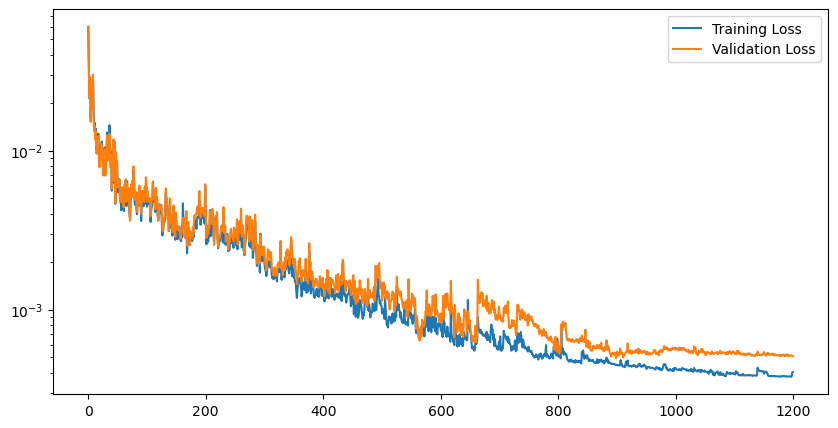

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
model_autoencoder

ModelAutoencoder(
  (model_psi): ModelPsi(
    (dic): DicNN(
      (input_layer): Linear(in_features=6957, out_features=128, bias=False)
      (hidden_layers): ModuleList(
        (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
      )
      (output_layer): Linear(in_features=128, out_features=256, bias=True)
      (inv_input_layer): Linear(in_features=256, out_features=128, bias=False)
      (inv_hidden_layers): ModuleList(
        (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
      )
      (inv_output_layer): Linear(in_features=128, out_features=6957, bias=True)
      (activation): Tanh()
    )
  )
  (model_inv_psi): ModelPsi()
)

In [16]:
x_data_scaled_tensor = torch.tensor(x_data_scaled, dtype=torch.float32)
err = x_data_scaled_tensor - model_autoencoder(x_data_scaled_tensor)
err_norm = torch.norm(err)
x_data_scaled_tensor_norm = torch.norm(x_data_scaled_tensor)
ratio = err_norm / x_data_scaled_tensor_norm
print(ratio)

tensor(0.0205, grad_fn=<DivBackward0>)


In [17]:
torch.save(model_autoencoder, 'model_autoencoder.pth')

## Test for middle layer

In [22]:
layer_sizes_m = [128, 128, 128, 128, 128]
model_latent = NonlinearMiddleLayer(layer_sizes_m, n_psi_train, u_dim)

In [23]:
x_train_latent = model_psi(x_train).detach()
y_train_latent = model_psi(y_train).detach()
x_test_latent = model_psi(x_test).detach()
y_test_latent = model_psi(y_test).detach()

# Create a dataset
dataset_latent = TensorDataset(x_train_latent, y_train_latent, u_train)

# Create a data loader
data_loader_latent = DataLoader(dataset_latent, batch_size=64, shuffle=True)


In [94]:
x_train_latent.shape

torch.Size([5776, 256])

In [95]:
# Define the optimizer
optimizer_latent = Adam(list(model_latent.parameters()) , lr=0.001)
scheduler_latent = StepLR(optimizer_latent, step_size=100, gamma=0.8)

mse_loss = nn.MSELoss()

epoches = 800

# Initialize a list to store the loss values
train_losses_latent = []
val_losses_latent = []

In [96]:
# Training process

for epoch in range(epoches):
    for x_batch, y_batch, u_batch in data_loader_latent:
        optimizer_latent.zero_grad()
        loss = mse_loss(model_latent(x_batch, u_batch), y_batch)
        loss.backward()
        optimizer_latent.step()
        
    
    train_loss = mse_loss(model_latent(x_train_latent, u_train), y_train_latent)
    train_loss_value = train_loss.item()
    train_losses_latent.append(train_loss_value)
        
    # Test the model
    with torch.no_grad():
        val_loss = mse_loss(model_latent(x_test_latent, u_test), y_test_latent)
        val_losses_latent.append(val_loss.item())

    current_lr = optimizer_latent.param_groups[0]['lr']
    scheduler_latent.step()
    print(f'Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Learning Rate: {current_lr}')


Epoch: 0, Training Loss: 0.46381375193595886, Validation Loss: 0.465346097946167, Learning Rate: 0.001
Epoch: 1, Training Loss: 0.31713661551475525, Validation Loss: 0.32081592082977295, Learning Rate: 0.001
Epoch: 2, Training Loss: 0.27599117159843445, Validation Loss: 0.27417147159576416, Learning Rate: 0.001
Epoch: 3, Training Loss: 0.256303071975708, Validation Loss: 0.2615835666656494, Learning Rate: 0.001
Epoch: 4, Training Loss: 0.2413053810596466, Validation Loss: 0.23918654024600983, Learning Rate: 0.001
Epoch: 5, Training Loss: 0.23483124375343323, Validation Loss: 0.23849350214004517, Learning Rate: 0.001
Epoch: 6, Training Loss: 0.23350465297698975, Validation Loss: 0.233523890376091, Learning Rate: 0.001
Epoch: 7, Training Loss: 0.225118026137352, Validation Loss: 0.22232618927955627, Learning Rate: 0.001
Epoch: 8, Training Loss: 0.21781417727470398, Validation Loss: 0.21699978411197662, Learning Rate: 0.001
Epoch: 9, Training Loss: 0.2160518616437912, Validation Loss: 0.2

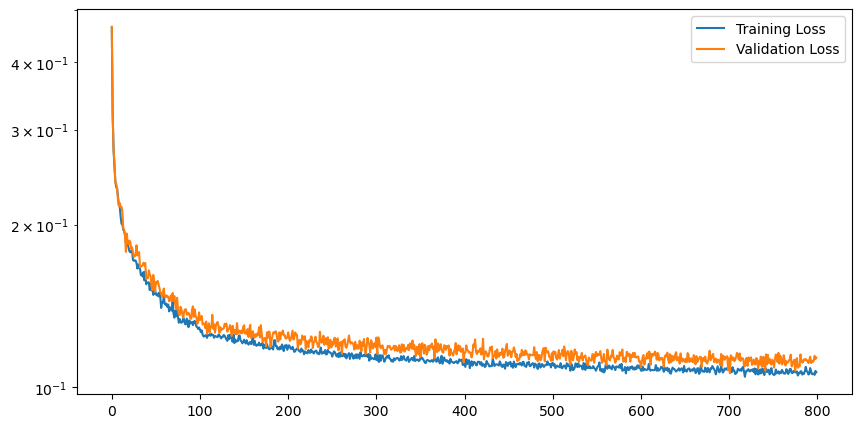

In [97]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses_latent, label='Training Loss')
plt.plot(val_losses_latent, label='Validation Loss')
plt.legend()
plt.yscale('log')
plt.show()

In [98]:
x_data_scaled_tensor = torch.tensor(x_data_scaled, dtype=torch.float32)
y_data_scaled_tensor = torch.tensor(y_data_scaled, dtype=torch.float32)
u_data_scaled_tensor = torch.tensor(u_data_scaled, dtype=torch.float32)
x_data_latent = model_psi(x_data_scaled_tensor)
y_data_latent = model_psi(y_data_scaled_tensor)
err = y_data_latent - model_latent(x_data_latent, u_data_scaled_tensor)
err_norm = torch.norm(err)
y_data_latent_norm = torch.norm(y_data_latent)
ratio = err_norm / y_data_latent_norm
print(ratio)

tensor(0.2513, grad_fn=<DivBackward0>)


## Parametric Koopman

In [24]:
layer_sizes_k = [128,128,128]
k_para = ParaKoopmanLayer(layer_sizes = layer_sizes_k, input_dim = u_dim, K_dim = n_psi_train)


In [25]:
import torch
import torch.nn as nn

class ModelKoopmanLayer(nn.Module):
    def __init__(self, layer_sizes_k):
        super(ModelKoopmanLayer, self).__init__()
        self.k_para = ParaKoopmanLayer(layer_sizes = layer_sizes_k, input_dim = u_dim, K_dim = n_psi_train)

    def forward(self, input_x, input_u):
        psi_x_expanded = input_x.unsqueeze(1)

        output_x = torch.bmm(psi_x_expanded, self.k_para(input_u))

        output_x = output_x.squeeze(1)

        return output_x


In [26]:
model_koopman = ModelKoopmanLayer(layer_sizes_k)

In [27]:
# Define the optimizer
optimizer_koopman = Adam(list(model_koopman.parameters()) , lr=0.001)
scheduler_koopman = StepLR(optimizer_koopman, step_size=50, gamma=0.8)

mse_loss = nn.MSELoss()

train_losses_koopman = []
val_losses_koopman = []

In [28]:
epoches = 1200

# Training process

for epoch in range(epoches):
    for x_batch, y_batch, u_batch in data_loader_latent:
        optimizer_koopman.zero_grad()
        loss = mse_loss(model_koopman(x_batch, u_batch), y_batch)
        loss.backward()
        optimizer_koopman.step()
        
    
    train_loss = mse_loss(model_koopman(x_train_latent, u_train), y_train_latent)
    train_loss_value = train_loss.item()
    train_losses_koopman.append(train_loss_value)
        
    # Test the model
    with torch.no_grad():
        val_loss = mse_loss(model_koopman(x_test_latent, u_test), y_test_latent)
        val_losses_koopman.append(val_loss.item())

    current_lr = optimizer_koopman.param_groups[0]['lr']
    scheduler_koopman.step()
    print(f'Epoch: {epoch}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}, Learning Rate: {current_lr}')


Epoch: 0, Training Loss: 0.1332898586988449, Validation Loss: 0.13864359259605408, Learning Rate: 0.001
Epoch: 1, Training Loss: 0.0970064103603363, Validation Loss: 0.10356081277132034, Learning Rate: 0.001
Epoch: 2, Training Loss: 0.08035942912101746, Validation Loss: 0.08868575841188431, Learning Rate: 0.001
Epoch: 3, Training Loss: 0.06475647538900375, Validation Loss: 0.07037606090307236, Learning Rate: 0.001
Epoch: 4, Training Loss: 0.05781722068786621, Validation Loss: 0.06416426599025726, Learning Rate: 0.001
Epoch: 5, Training Loss: 0.05304282531142235, Validation Loss: 0.058488015085458755, Learning Rate: 0.001
Epoch: 6, Training Loss: 0.05157061666250229, Validation Loss: 0.056218136101961136, Learning Rate: 0.001
Epoch: 7, Training Loss: 0.04869601130485535, Validation Loss: 0.05267907306551933, Learning Rate: 0.001
Epoch: 8, Training Loss: 0.04783199727535248, Validation Loss: 0.05166715756058693, Learning Rate: 0.001
Epoch: 9, Training Loss: 0.052008599042892456, Validati

In [29]:
x_data_scaled_tensor = torch.tensor(x_data_scaled, dtype=torch.float32)
y_data_scaled_tensor = torch.tensor(y_data_scaled, dtype=torch.float32)
u_data_scaled_tensor = torch.tensor(u_data_scaled, dtype=torch.float32)
x_data_latent = model_psi(x_data_scaled_tensor)
y_data_latent = model_psi(y_data_scaled_tensor)
err = y_data_latent - model_koopman(x_data_latent, u_data_scaled_tensor)
err_norm = torch.norm(err)
y_data_latent_norm = torch.norm(y_data_latent)
ratio = err_norm / y_data_latent_norm
print(ratio)

tensor(0.0619, grad_fn=<DivBackward0>)
